In [36]:
# !pip install numpy seaborn pandas scipy

In [37]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

ERR = 1e-10
STARTING_AGE = 20
MAX_EXTRA_YEARS = 150 - STARTING_AGE

# Part 1: The Live-Death Model

## Ultimate Survival Model

Define
$$
\mu_x = A + Bc^x
$$
where $A = 0.00022, B = 2.7\times10^{-6}, c = 1.124$.

Then, let $T$ be the lifespan of a person. We denote
$$
\begin{align*}
    {}_t p_x &= \Pr[T > x+t | T > x] \\
             &= e^{-\int_{s=0}^t \mu_{x+s}} \, ds
\end{align*}
$$
where $x$ is the starting age and $t$ is the number of years left.

In [38]:
from scipy.integrate import quad

def compute_mu(x):
    A = 0.00022
    B = 2.7e-6
    c = 1.124
    return A + B * c**x

def prob_of_living(x0, t):
    """
    x = current age
    t = number of years left
    => Pr[Living another t years | You are x y/o]
    """
    integral_val, _ = quad(lambda s: compute_mu(x0 + s), 0, t)
    return np.exp(-integral_val)

<Axes: xlabel="$t$'s", ylabel='Pr[Living t more years]'>

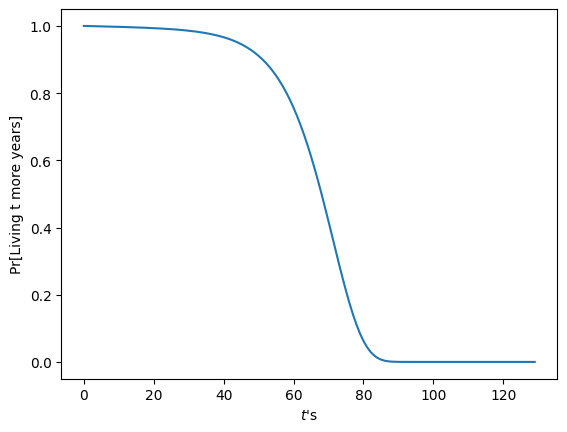

In [39]:
ts = np.arange(0, MAX_EXTRA_YEARS)
ys = np.array([prob_of_living(STARTING_AGE, t) for t in ts])

tp_data = pd.DataFrame({
    "$t$'s": ts,
    "Pr[Living t more years]": ys,
})

sns.lineplot(tp_data, x="$t$'s", y="Pr[Living t more years]")

## Modeling this as a Markov Chain

Let $S = \{A \text{(Alive)}, D \text{(Dead)}\}$. Obviously, $D$ is a recurrent state. We want to find the transition probability $A \to D$. Denote

$$
\begin{align*}
{}_k q_x &= \Pr[x+k \leq T \leq x+k+1 | T > x] \\
         &= {}_k p_x - {}_{k+1} p_x
\end{align*}
$$

Lastly, define the sequence of transition matrices $\{P_x(t)\}_{t=0}^\infty$
$$
P_x(t) = \begin{bmatrix}
    1 - {}_t q_x & {}_t q_x \\
    0 & 1
\end{bmatrix}
$$

<Axes: xlabel="$t$'s">

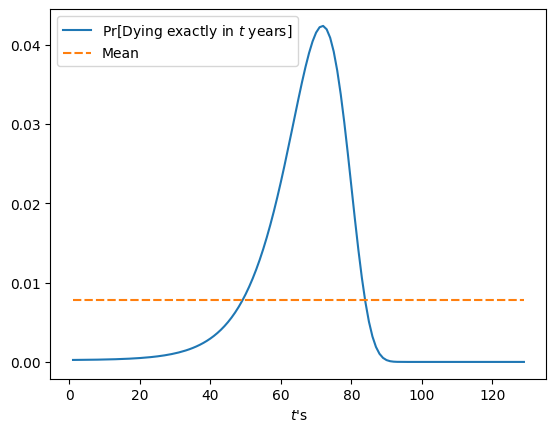

In [40]:
qs = np.array([ys[i-1] - ys[i] for i in range(1, MAX_EXTRA_YEARS)])
qs_mean = np.mean(qs)

tq_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "Pr[Dying exactly in $t$ years]": qs,
    "Mean": qs_mean,
}).set_index("$t$'s")

sns.lineplot(tq_data)

Since this computation is rather expensive, we will try to look at alternative ways to compute ${}_t q_x$. Namely, we will try to fit it to some function or a known probability distribution. We have two choices here:
- A function that has a sharp increase and sharp decrease. This is very simple but it will not capture the shape of the curve very well.
- Skew Normal Distribution. This should give us higher precision compared to the simple function but will also be more expensive to compute.

In the end, the simple function used to fit ${}_t q_x$'s is
$$ f(x) = a \cdot \left(e^{-\frac{(x-b)^2}{c}}\right) $$
Yes, ChatGPT gave me this idea but not this exact function.

Obviously, we also tried with the Skew Normal Distribution.

In [41]:
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

def fitting_func(x, a, b, c):
    return a * np.exp(- (x-b)**2 / c)

def sn_fitting_func(x, xi, omg, alpha):
    return skewnorm.pdf(x, xi, omg, alpha)

opt_params, _ = curve_fit(fitting_func, ts[1:], qs)
sn_opt_params, _ = curve_fit(sn_fitting_func, ts[1:], qs, maxfev=10_000)
a0, b0, c0 = opt_params
xi0, omega0, alpha0 = sn_opt_params

fitted_qf = lambda x: fitting_func(x, a0, b0, c0)
sn_fitted_qf = lambda x: sn_fitting_func(x, xi0, omega0, alpha0)

(a0, b0, c0), (xi0, omega0, alpha0)

((0.041508724037767966, 69.53109822447348, 167.62261794499818),
 (-3.339337614202206, 79.3691295630149, 15.835651618254337))

<Axes: xlabel="$t$'s">

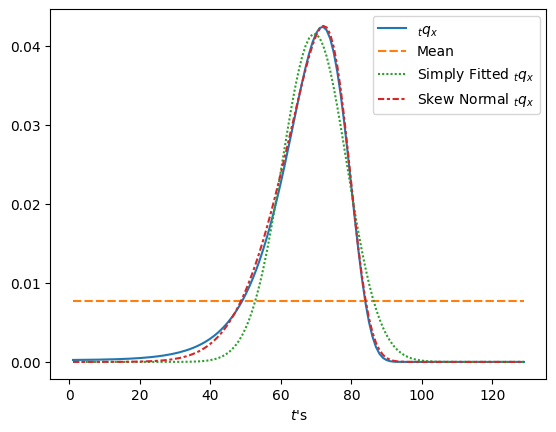

In [42]:
fitting_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "${}_t q_x$": qs,
    "Mean": qs_mean,
    "Simply Fitted ${}_t q_x$": [fitted_qf(t) for t in ts[1:]],
    "Skew Normal ${}_t q_x$": [sn_fitted_qf(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(fitting_data)

## Expected Time to Live

An easy way out is to just compute
$$
\text{E}[T] = \sum_{t=0}^\infty t \cdot {}_t q_x
$$

Note: The computation here cuts off at around $t$ no more than 100-120 as at that point, the ${}_t q_x$ is so low that it will not contribute much more to the expected value. In fact, it is to the point that the precision is already lost due to floating-point arithmetics.

In [43]:
expected_extra_live = ts[1:] @ qs
expected_extra_live, STARTING_AGE + expected_extra_live

(66.41315159665601, 86.41315159665601)

In [44]:
from scipy.optimize import fsolve

def compute_q(x0, t):
    t1 = prob_of_living(x0, t)
    t2 = prob_of_living(x0, t - 1)
    return t2 - t1

def compute_expected_at(t):
    q = compute_q(STARTING_AGE, t)
    
    def f_to_solve(mu):
        return 1 + (1 - q)*mu - mu
        
    soe_soln = fsolve(f_to_solve, [0])
    return soe_soln

In [45]:
# np.mean([compute_expected_at(t) for t in ts[1:]])
compute_expected_at(20)

array([2039.53822292])

# Part 2: The General Model

Obviously, people get sick. Once people get sick, they become more likely to die. We will now incorporate this into our model. Specifically, we will only add cancer into this model because just by doing so already increases the complexity by a lot.

Consider the state space $S = \{A, C, D\}$ where $C$ is for cancer (multiple myeoloma, specifcally) and $A$ and $D$ are from before. Additionally define $c_t$ to be the probability of getting cancer at year $t$ and $r_t$ be the probability of recovering from cancer at year $t$.
$$
P = \begin{bmatrix}
    1 - {}_t c_x - {}_t q_x & {}_t c_x & {}_t q_x \\
    r_t & \\
    0 & 0 & 1
\end{bmatrix}
$$

### Finding the Rate of Getting Cancer

Although there is probably a USM-like model out there for predicting cancer, I couldn't find it :/
So, we are going to stick with the good old method of *fitting a simple function*. The function in question is
$$
f(x) = a\exp\left({-\frac{(x-b)^2}{c}}\right)
$$
(i.e., the function from before.)

The data is from the [SEER Program, NIH](https://seer.cancer.gov/statistics-network/explorer/application.html?site=1&data_type=1&graph_type=3&compareBy=sex&chk_sex_1=1&rate_type=2&race=1&advopt_precision=1&hdn_view=0) so it is mostly based on U.S. data.

In [46]:
cancer_rate_df = pd.read_csv("data/cancer_diag_rate.csv").drop(["Lower 95% C.I.", "Upper 95% C.I."], axis=1)
cancer_rate_df["Age at Diagnosis"] = cancer_rate_df["Age at Diagnosis"].map(lambda s: int(s.split("-")[-1]))
cancer_rate_df["Rate per 100,000"] = cancer_rate_df["Rate per 100,000"].map(lambda r: r / 100_000)
cancer_rate_df = cancer_rate_df.set_index("Age at Diagnosis")
cancer_rate_df

,"Rate per 100,000"
Age at Diagnosis,
1,0.000264
4,0.000227
9,0.000134
14,0.000165
19,0.000251
24,0.000388
29,0.000603
34,0.000986
39,0.001478


<Axes: xlabel='Age at Diagnosis', ylabel='Fitted Probability'>

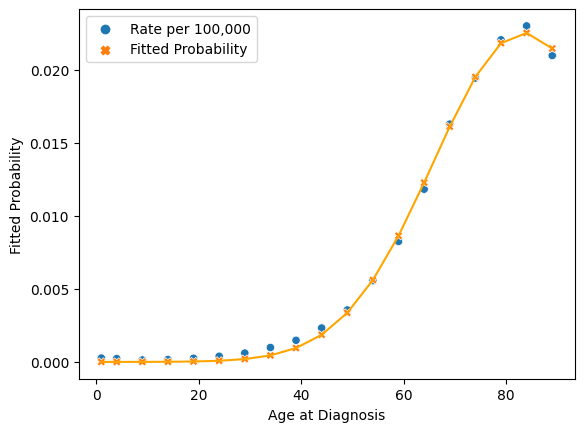

In [47]:
cr_popt, _ = curve_fit(fitting_func, cancer_rate_df.index, cancer_rate_df["Rate per 100,000"])
a1, b1, c1 = cr_popt
cancer_rate_df["Fitted Probability"] = fitting_func(cancer_rate_df.index, a1, b1, c1)

sns.lineplot(cancer_rate_df["Fitted Probability"], color="orange")
sns.scatterplot(cancer_rate_df)

<Axes: xlabel="$t$'s">

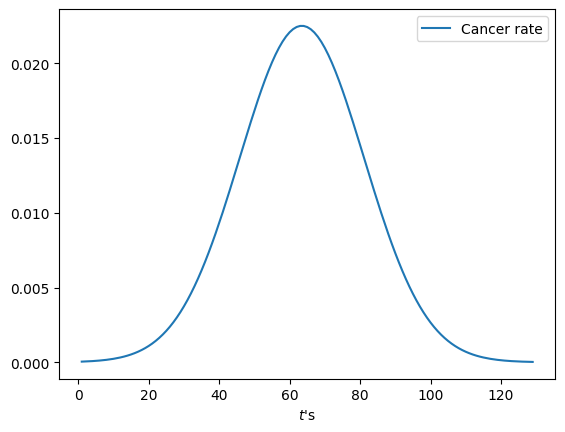

In [48]:
compute_cancer_rate = lambda t: fitting_func(t + STARTING_AGE, a1, b1, c1)

cancer_df = pd.DataFrame({
    "$t$'s": ts[1:],
    "Cancer rate": [compute_cancer_rate(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(cancer_df)

### Cancer Mortality Rate

In [60]:
cancer_death_df = pd.read_csv("data/IHME-GBD_2019_DATA-d5aa04a7-1.csv").drop(["year", "upper", "lower", "measure", "location", "sex", "cause", "metric"], axis=1)
cancer_death_df["age"] = cancer_death_df["age"].map(lambda s: s.split(" ")[0].split("-")[-1])
cancer_death_df = cancer_death_df.set_index("age")

<Axes: xlabel='age'>

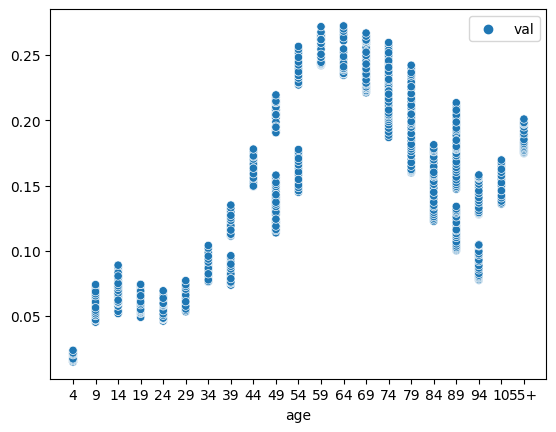

In [61]:
sns.scatterplot(cancer_death_df)